# Simulate reaction with signal

### Imports

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import numpy as np
from functools import partial
import diffrax as dfx

from bioreaction.misc.misc import load_json_as_dict, per_mol_to_per_molecules
from bioreaction.model.data_containers import QuantifiedReactions
from bioreaction.model.data_tools import construct_model
from bioreaction.simulation.simfuncs.basic_de import basic_de_sim, one_step_de_sim

## Test with single species

In [2]:

def x(t, total_time, dt, step_signal):  # control signal
    return step_signal * t / (total_time / dt)

def step_function(t, total_time, num_steps):
    return jnp.floor_divide(t, total_time / num_steps)

# exponential decay subject to affine control
def fbioreaction(t, y, args, x=None):
    return -y + x(t)

t0, t1, dt0 = 0, 60, 0.1
# signal = partial(x, total_time=t1, dt=dt0, step_signal=4)
signal = partial(step_function, total_time=t1, num_steps=3)

term = dfx.ODETerm(partial(fbioreaction, x=signal))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)
sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=1, saveat=saveat)


/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


In [3]:
%timeit dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=1, saveat=saveat)

276 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


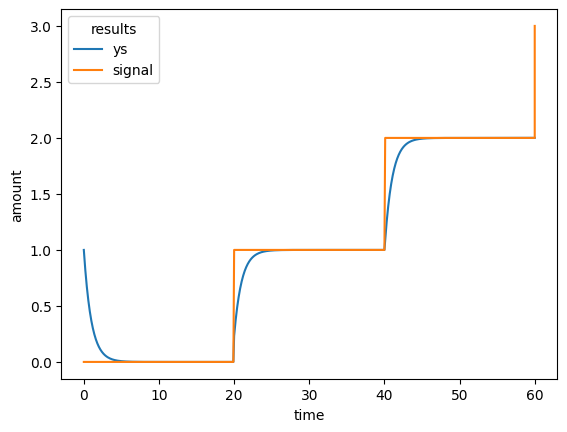

In [4]:
# plt.plot(sim_result.ts, sim_result.ys)
# plt.plot(sim_result.ts, [signal(t) for t in sim_result.ts])
# plt.show()

data = pd.DataFrame()
data['time'] = sim_result.ts
data['ys'] = sim_result.ys
data['signal'] = np.array([signal(t) for t in sim_result.ts])

dfm = data.melt('time', var_name='results', value_name='amount')
sns.lineplot(x='time', y='amount', hue='results', data=dfm)  # , kind='point')
plt.savefig('signals.png')

## Test with multiple species

In [126]:
config = load_json_as_dict('../scripts/playground_signals/simple_config.json')
model = construct_model(config)

# config['forward_rates'][3:9] = per_mol_to_per_molecules(config['forward_rates'][3:9])
# config['reverse_rates'][3:9] = per_mol_to_per_molecules(config['reverse_rates'][3:9])
qreactions = QuantifiedReactions()
qreactions.init_properties(model, config)


def step_function(t, total_time, step_num, dt, target):
    # return (jnp.floor_divide(t, (total_time - dt) / step_num) - \
    #     jnp.floor_divide(t, (total_time  + dt) / step_num) ) * (target/dt)
    # return jnp.floor_divide(t, (total_time - dt) / step_num) * (target/dt)
    return jnp.where((30 < t) & (t < 31), 1, 0)

# exponential decay subject to affine control
def fbioreaction(t, y, args, x=0, signal_onehot=1):
    return -y * signal_onehot + x(t) * (-signal_onehot + 1)


signal_species = [s for s in model.species if s.name == "RNA1" or s.name == "RNA2"]
signal_onehot = np.ones(len(model.species))
for s in signal_species:
    signal_onehot[model.species.index(s)] = 0

t0, t1, dt0 = 0, 60, 0.1
# signal = partial(x, total_time=t1, dt=dt0, step_signal=4)
signal = partial(step_function, total_time=t1, step_num=2, dt=dt0, target=1000)

term = dfx.ODETerm(partial(fbioreaction, x=signal, signal_onehot=signal_onehot))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)
sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, 
    y0=qreactions.quantities * signal_onehot, saveat=saveat)


/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


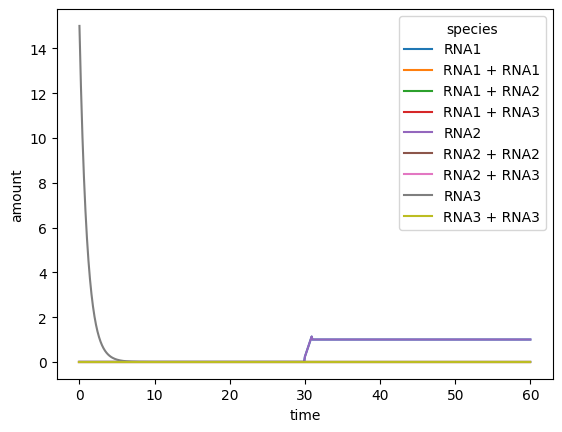

In [127]:
def make_sns_vis(model, ts, ys, rem_cols: list = ['dRNA1', 'dRNA2', 'dRNA3', 'aRNA1', 'aRNA2', 'aRNA3']):
    data = pd.DataFrame(columns=[str(s.name) for s in model.species], data=ys)
    data.drop(columns=rem_cols, inplace=True)
    data['time'] = ts
    # data['signal'] = np.array([signal(t) for t in sim_result.ts])

    dfm = data.melt('time', var_name='species', value_name='amount')
    sns.lineplot(x='time', y='amount', hue='species', data=dfm)  # , kind='point')
    plt.savefig('signals.png')

make_sns_vis(model, sim_result.ts, sim_result.ys, rem_cols=[])

### Bigger simulation?

In [105]:
t0, t1, dt0 = 0, 100, 0.2

signal = partial(step_function, total_time=t1, step_num=2, dt=dt0, target=100)
term = dfx.ODETerm(partial(fbioreaction, x=signal, signal_onehot=signal_onehot))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)

sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, 
    y0=qreactions.quantities * signal_onehot, saveat=saveat, max_steps=16**4)


/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


In [106]:
ys = sim_result.ys[:len(sim_result.ts) - sum(sim_result.ts == np.inf)]
ts = sim_result.ts[:len(sim_result.ts) - sum(sim_result.ts == np.inf)]
make_sns_vis(model, ts, ys)


KeyError: "['dRNA1', 'dRNA2', 'dRNA3', 'aRNA1', 'aRNA2', 'aRNA3'] not found in axis"

## Actual bioreaction DE simulation

In [175]:
config = load_json_as_dict('../scripts/playground_signals/simple_config.json')
model = construct_model(config)

qreactions = QuantifiedReactions()
qreactions.init_properties(model, config)

def step_function(t, total_time, step_num, dt, target):
    return (jnp.sin(t) + 1)* jnp.where((10 < t) & (t < 130), target/24, 0)

def one_step_de_sim(spec_conc, reactions, delta_t: float):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (reactions.inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (reactions.outputs)), axis=1)
    forward_delta = concentration_factors_in * reactions.forward_rates
    reverse_delta = concentration_factors_out * reactions.reverse_rates
    return (forward_delta - reverse_delta) @ (reactions.outputs - reactions.inputs) 

def bioreaction_sim(t, y, args, reactions, signal, signal_onehot, dt):
    return one_step_de_sim(spec_conc=y,
                           reactions=reactions, delta_t=1) + signal(t) * signal_onehot

t0, t1, dt0 = 0, 200, 0.02

signal_species = [s for s in model.species if s.name in (f"RNA{i}" for i in [1,2,3]) ]# or s.name=="RNA3"]
signal_onehot = np.zeros(len(model.species))
for s in signal_species:
    signal_onehot[model.species.index(s)] = 1

signal = partial(step_function, total_time=t1, step_num=2, dt=dt0, target=10)
term = dfx.ODETerm(partial(bioreaction_sim, reactions=qreactions.reactions, signal=signal,
                   signal_onehot=signal_onehot, dt=dt0))
solver = dfx.Tsit5()
saveat = dfx.SaveAt(t0=True, t1=True, steps=True)

sim_result = dfx.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0,
                             y0=qreactions.quantities,# * (1-signal_onehot),
                             saveat=saveat, max_steps=16**4)


/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/wadh6511/Kode/env_bioreaction/lib/python3.10/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


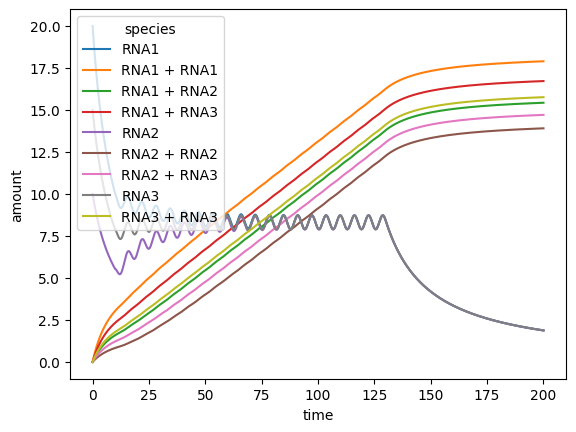

In [176]:
result_range = len(sim_result.ts) - sum(sim_result.ts == np.inf)
# result_range = 10
ys = sim_result.ys[:result_range]
ts = sim_result.ts[:result_range]
make_sns_vis(model, ts, ys, rem_cols = [])#, rem_cols=['RNA1 + RNA1', 'RNA1 + RNA2', 'RNA1 + RNA3', 'RNA2 + RNA2', 'RNA2 + RNA3', 'RNA3 + RNA3'])
